# Benchmark Analysis between 3D-GNOME and cudaMMC

Comparison of two methods:

- **3D-GNOME (Latest Version)**: [3D-GNOME Bitbucket Repository](https://bitbucket.org/3dome/3dgnome)
- **cudaMMC**: This is a GPU-enhanced extension of 3D-GNOME. [cudaMMC GitHub Repository](https://github.com/SFGLab/cudaMMC)


In [1]:
import os
import statistics

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def take_times_from_files_calc_average_time(list_of_filenames):
    """
    Extracts processing times from a list of files and calculates average time and 
    coefficient of variation per chromosome.

    This function assumes each file in the list contains a processing time on its first line 
    and is named in a way that the chromosome name can be extracted from the filename.
    For example, for a filename "/path/to/chromosomeX_data.txt", "chromosomeX" will be 
    the extracted chromosome name.

    Parameters:
    - list_of_filenames (list of str): A list of file paths to be processed.

    Returns:
    - results_average (dict): A dictionary where keys are chromosome names and values 
      are the average processing times for each chromosome.
    - results_coefficient_of_variation (dict): A dictionary where keys are chromosome 
      names and values are the coefficient of variation (standard deviation/mean) 
      of the processing times for each chromosome.

    Note:
    The coefficient of variation is a measure of relative variability. It is useful for 
    comparing the degree of variation from one data series to another, even if the means 
    are drastically different from one another.
    """

    results = {}
    results_average = {}
    results_coefficient_of_variation = {}
    
    for i in list_of_filenames:
        with open(i, 'r') as f:
            t=float(f.readline())
            chrom_name = i.split('/')[-1].split('_')[0]
            if chrom_name in results.keys():
                results[chrom_name].append(t)
            else:
                results[chrom_name]=[t]    
    
    for key, value in results.items():
        mean_of_chrom = statistics.mean(results[key])
        st_dev_of_chrom = statistics.stdev(results[key])
        
        results_average[key] = mean_of_chrom
        results_coefficient_of_variation[key] = st_dev_of_chrom/mean_of_chrom
        
    return results_average, results_coefficient_of_variation


In [3]:
def convert_results_to_pandas(results_average, results_average_coef_var, method_name):
    """
    Converts provided results dictionaries into a single Pandas DataFrame.

    This function takes in two dictionaries containing average results and 
    coefficients of variation and transforms them into two Pandas DataFrames. 
    It then merges the two DataFrames into one based on the chromosome index 
    and returns the merged DataFrame.

    Parameters:
    - results_average (dict): A dictionary where keys are chromosome names 
      (or indices) and values are the average processing times for each chromosome.
    - results_average_coef_var (dict): A dictionary where keys are chromosome names 
      (or indices) and values are the coefficient of variation of the processing 
      times for each chromosome.
    - method_name (str): A string representing the name of the method/technique 
      being used. This is used to label the columns in the resulting DataFrame.

    Returns:
    - merged_data (DataFrame): A DataFrame containing two columns: 
      one for the average results and one for the coefficients of variation, 
      both indexed by chromosome.

    Note:
    This function assumes that the keys in the provided dictionaries (chromosome names) 
    are numeric or can be converted to numeric for sorting purposes. The resulting 
    DataFrame will have chromosomes sorted in numeric order.
    """

    pd_results_average = pd.DataFrame(results_average, index=[0]).transpose()
    pd_results_average = pd_results_average.reset_index()
    pd_results_average['index'] = pd.to_numeric(pd_results_average['index'])
    pd_results_average = pd_results_average.sort_values('index').set_index('index')
    pd_results_average.columns = [method_name]
    
    pd_results_average_coef_var = pd.DataFrame(results_average_coef_var, index=[0]).transpose()
    pd_results_average_coef_var = pd_results_average_coef_var.reset_index()
    pd_results_average_coef_var['index'] = pd.to_numeric(pd_results_average_coef_var['index'])
    pd_results_average_coef_var = pd_results_average_coef_var.sort_values('index').set_index('index')
    pd_results_average_coef_var.columns = [f'{method_name}_coef_var']
    
    merged_data = pd.merge(pd_results_average, pd_results_average_coef_var, left_on='index', right_on='index')
    return merged_data


## Benchmark Setup Steps

1. **Installation**: Install 3dnome and cudaMMC from the repositories.
2. **Run the Script**: Execute the `benchmark_modelling_methods.py` script. This script can be found in the `cudaMMC` repository under the `benchmark` directory. After running this, you can use your results for further benchmarking analysis.


## Time Performance Analysis

Initially, we will assess both the time performance and the Coefficient of Variation of the algorithm's time performance across chromosomes. This analysis utilizes smaller datasets derived from the `hg19` long-read CTCF ChIA-PET experiment. The examination encompasses all autosomal chromosomes.


In [4]:
#set your dir with results:

In [5]:
cd tests/tests_results/

/home/michal/Projects/cudaMMC_calculations/tests/tests_results


In [6]:
paths_3dnome_logs = 'logs/3dnome/3dnome_logs_single_runs/'
paths_cudaMMC_logs = 'logs/cudaMMC/cudaMMC_logs_single_runs/'
path_to_chrom_sizes = "data/hg19/human_hg19_chrom_sizes.txt" #find in benchmark dir

In [7]:
files_time_cpu = [os.path.join(paths_3dnome_logs, fname) for fname in os.listdir(paths_3dnome_logs) if fname.endswith('txt')]
files_time_gpu = [os.path.join(paths_cudaMMC_logs, fname) for fname in os.listdir(paths_cudaMMC_logs) if fname.endswith('txt')]


In [8]:
results_gpu, results_gpu_coef_var = take_times_from_files_calc_average_time(files_time_gpu)
results_cpu, results_cpu_coef_var = take_times_from_files_calc_average_time(files_time_cpu)

In [9]:
pd_results_gpu = convert_results_to_pandas(results_gpu,results_gpu_coef_var, 'gpu_times')
pd_results_cpu = convert_results_to_pandas(results_cpu,results_cpu_coef_var, 'cpu_times')

In [10]:
merged_pd_results = pd.merge(pd_results_cpu, pd_results_gpu, left_on=pd_results_cpu.index, right_on=pd_results_gpu.index).rename(columns={'key_0':"chr_id"})

In [11]:
speed_up = []
for index, row in merged_pd_results.iterrows():
    speed_up.append(row['cpu_times']/row['gpu_times']*100)

merged_pd_results['speed_up'] = speed_up
chr_names = [f'chr{i}' for i in list(merged_pd_results['chr_id'])]
merged_pd_results['chr_names'] = chr_names
chrom_sizes = pd.read_csv(path_to_chrom_sizes,sep='\t', header=None)
chrom_sizes.columns = ['chr_names', 'chrom_size']

In [12]:
merged_pd_results['cpu_times_min'] = (merged_pd_results['cpu_times']/60).round(2)
merged_pd_results['gpu_times_min'] = (merged_pd_results['gpu_times']/60).round(2)

In [13]:
merged_pd_results_chrom_sizes = pd.merge(merged_pd_results, chrom_sizes, how='left', on='chr_names')
merged_pd_results_chrom_sizes = merged_pd_results_chrom_sizes.sort_values(by='chrom_size')
chr_size_small = [i/1000000 for i in list(merged_pd_results_chrom_sizes['chrom_size'])]
merged_pd_results_chrom_sizes['chr_size_small']=chr_size_small
merged_pd_results_chrom_sizes = merged_pd_results_chrom_sizes.sort_values(by='chr_size_small')
merged_pd_results_chrom_sizes.head()

,chr_id,cpu_times,cpu_times_coef_var,gpu_times,gpu_times_coef_var,speed_up,chr_names,cpu_times_min,gpu_times_min,chrom_size,chr_size_small
20,21,70.285068,0.064486,20.127466,0.020129,349.199789,chr21,1.17,0.34,48129895,48.129895
21,22,172.469018,0.060234,26.141358,0.028638,659.755388,chr22,2.87,0.44,51304566,51.304566
18,19,360.093128,0.158354,37.500894,0.019712,960.225451,chr19,6.00,0.63,59128983,59.128983
19,20,253.664935,0.056100,31.955694,0.011885,793.801988,chr20,4.23,0.53,63025520,63.025520
17,18,201.681090,0.150578,31.185421,0.014987,646.715946,chr18,3.36,0.52,78077248,78.077248


<Figure size 432x288 with 0 Axes>

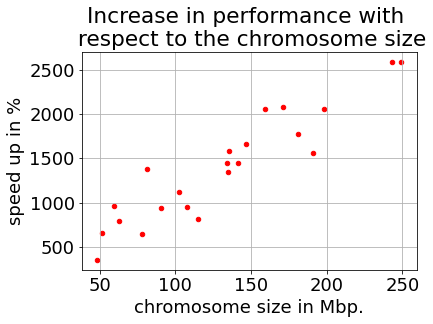

In [14]:
plt.clf()
plt.rcParams.update({'font.size': 18})
merged_pd_results_chrom_sizes.plot.scatter(x = 'chr_size_small', y = 'speed_up', title = "Increase in performance with \n respect to the chromosome size", c = 'red', xlabel="chromosome size in bp.", ylabel="speed up in %", grid=True)#, s = 'chrom_size');  
plt.xlabel('chromosome size in Mbp.')
plt.ylabel('speed up in %')
plt.figsize = (2.36,1.57)
# plt.savefig("figures/performance_hg19_speed_up_300dpi_after.png", format='png',dpi=300,bbox_inches='tight',pad_inches=0.1)
plt.show()

<Figure size 432x288 with 0 Axes>

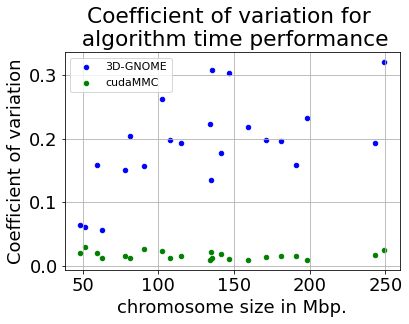

In [15]:
plt.clf()
plt.figsize = (2.36,1.57)
plt.rcParams.update({'font.size': 18})
plt.tight_layout()
ax=merged_pd_results_chrom_sizes.plot(x = 'chr_size_small', y = 'cpu_times_coef_var', kind='scatter', title = "Coefficient of variation for \n algorithm time performance", c = 'blue')
merged_pd_results_chrom_sizes.plot(x = 'chr_size_small', y = 'gpu_times_coef_var', kind='scatter',ax=ax, c = 'green')

plt.xlabel('chromosome size in Mbp.')
plt.ylabel('Coefficient of variation')
plt.legend(["3D-GNOME", "cudaMMC"], loc='upper left', frameon=True, fontsize=11)
plt.grid()

# plt.savefig("figures/coef_var.png",dpi=300,bbox_inches='tight',pad_inches=0.1)
plt.show()

In [16]:
merged_pd_results_chrom_sizes

,chr_id,cpu_times,cpu_times_coef_var,gpu_times,gpu_times_coef_var,speed_up,chr_names,cpu_times_min,gpu_times_min,chrom_size,chr_size_small
20,21,70.285068,0.064486,20.127466,0.020129,349.199789,chr21,1.17,0.34,48129895,48.129895
21,22,172.469018,0.060234,26.141358,0.028638,659.755388,chr22,2.87,0.44,51304566,51.304566
18,19,360.093128,0.158354,37.500894,0.019712,960.225451,chr19,6.00,0.63,59128983,59.128983
19,20,253.664935,0.056100,31.955694,0.011885,793.801988,chr20,4.23,0.53,63025520,63.025520
17,18,201.681090,0.150578,31.185421,0.014987,646.715946,chr18,3.36,0.52,78077248,78.077248
16,17,645.013491,0.204972,46.746135,0.012088,1379.822083,chr17,10.75,0.78,81195210,81.195210
15,16,360.820090,0.156666,38.419104,0.026036,939.168423,chr16,6.01,0.64,90354753,90.354753
14,15,447.699067,0.262184,39.821931,0.022703,1124.252524,chr15,7.46,0.66,102531392,102.531392
13,14,376.040273,0.197917,39.416648,0.012373,954.013838,chr14,6.27,0.66,107349540,107.349540
12,13,284.690888,0.193448,35.200097,0.014523,808.778702,chr13,4.74,0.59,115169878,115.169878


## Comparing Time Performance 

In the subsequent step, we compared the time performance between an ensemble of 100 model runs by both methods.


In [17]:
def convert_results_ensemble_to_pandas(results_average, method_name):

    pd_results_average = pd.DataFrame(results_average, index=[0]).transpose()
    pd_results_average = pd_results_average.reset_index()
    pd_results_average['index'] = pd.to_numeric(pd_results_average['index'])
    pd_results_average = pd_results_average.sort_values('index').set_index('index')
    pd_results_average.columns = [method_name]
    return pd_results_average

In [18]:
paths_3dnome_ensemble_logs = 'logs/3dnome/3dnome_ensemble100_logs/'
paths_cudaMMC_ensemble_logs = 'logs/cudaMMC/cudaMMC_ensemble100_logs/'

In [19]:
files_time_cpu_ensemble = [os.path.join(paths_3dnome_ensemble_logs, fname) for fname in os.listdir(paths_3dnome_ensemble_logs) if fname.endswith('txt')]
files_time_gpu_ensemble = [os.path.join(paths_cudaMMC_ensemble_logs, fname) for fname in os.listdir(paths_cudaMMC_ensemble_logs) if fname.endswith('txt')]


In [20]:
results_gpu_ensemble, _ = take_times_from_files_calc_average_time(files_time_gpu_ensemble)
results_cpu_ensemble, _ = take_times_from_files_calc_average_time(files_time_cpu_ensemble)

In [21]:
pd_results_cpu_ensemble = convert_results_ensemble_to_pandas(results_cpu_ensemble,'cpu_times')
pd_results_gpu_ensemble = convert_results_ensemble_to_pandas(results_gpu_ensemble,'gpu_times')

In [22]:
merged_pd_results_ensemble = pd.merge(pd_results_cpu_ensemble, pd_results_gpu_ensemble, left_on=pd_results_cpu_ensemble.index, right_on=pd_results_gpu_ensemble.index)#.renameset_index('key_0')
merged_pd_results_ensemble.columns = ['chr_id', 'cpu_times', 'gpu_times']
merged_pd_results_ensemble['chr_names'] = ['chr1', 'chr14', 'chr21']

In [23]:
merged_pd_results_ensemble['cpu_times_min'] = (merged_pd_results_ensemble['cpu_times']/60).round(2)
merged_pd_results_ensemble['gpu_times_min'] = (merged_pd_results_ensemble['gpu_times']/60).round(2)

In [24]:
merged_pd_results_ensemble

,chr_id,cpu_times,gpu_times,chr_names,cpu_times_min,gpu_times_min
0,1,257021.497751,5959.989844,chr1,4283.69,99.33
1,14,33601.737308,2100.281302,chr14,560.03,35.00
2,21,5087.671860,612.311220,chr21,84.79,10.21


In [25]:
merged_pd_results_ensemble_2plot=merged_pd_results_ensemble[['chr_names', 'cpu_times_min', 'gpu_times_min']]

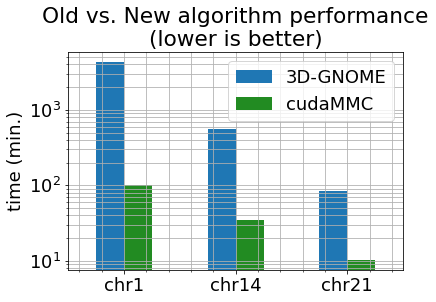

In [26]:
plt.rcParams.update({'font.size': 18})
ax =merged_pd_results_ensemble_2plot.plot.bar(x='chr_names', rot=0, grid=True, xlabel=False, title='Old vs. New algorithm performance\n(lower is better)', color=['tab:blue', 'forestgreen'])
ax.set_yscale('log')
ax.set_xlabel("")
ax.set_ylabel("time (min.)")
ax.minorticks_on()
ax.grid(True, which='both')
plt.legend(["3D-GNOME", "cudaMMC"], loc=0, frameon=True)
plt.figsize = (2.36,1.57)

# plt.savefig("figures/performance_ensembles_hg19_cpu_vs_gpu",dpi=300,bbox_inches='tight',pad_inches=0.1)
plt.show()

## Time Performance Analysis on Large Datasets

The subsequent phase of our benchmarking involved computing the average time performance using extensive data derived from the in situ CTCF ChIA-PET experiment mapped onto the `hg38` genome. This evaluation was conducted on chromosomes chr1, chr14, and chr21. Notably, we exclusively employed cudaMMC for this task. While 3D-GNOME is efficient for smaller datasets, it struggled to complete the modeling process for larger datasets within a reasonable timeframe.


In [27]:
paths_cudaMMC_single_logs = 'logs/cudaMMC/cudaMMC_single_runs_hg38/'
files_time_gpu_single_hg38 = [os.path.join(paths_cudaMMC_single_logs, fname) for fname in os.listdir(paths_cudaMMC_single_logs) if fname.endswith('txt')]
results_cpu_single_hg38, _ = take_times_from_files_calc_average_time(files_time_gpu_single_hg38)

In [28]:
pd_results_gpu_single_hg38 = convert_results_ensemble_to_pandas(results_cpu_single_hg38,'gpu_times')
pd_results_gpu_single_hg38['gpu_times_min'] = (pd_results_gpu_single_hg38['gpu_times']/60).round(2)
pd_results_gpu_single_hg38

,gpu_times,gpu_times_min
index,,
1,2999.963988,50.00
14,991.333470,16.52
21,259.713843,4.33


## Quality Comparison Between cudaMMC and 3D-GNOME 

We also assessed the quality of modeling produced by cudaMMC in relation to 3D-GNOME. The similarity matrices were computed in both ensembles of models using the embedded procedure provided in both methods.

Citing from the official manual:
> With the "-a ensemble" option, we instruct the software to perform the ensemble analysis. The `-i` option specifies the directory containing the structures, while `-p` provides the ensemble filenames pattern. `{N}` represents the serial number automatically appended in the prior step. The software matches this pattern against the files in the designated directory, using all the matching files for the analysis. This evaluation spans all three primary levels, resulting in similarity matrices saved within the same directory. The matrices are named as `structural_distances_lvlM.heat`, where `M` indicates the level (0 for chromosome, 1 for segment, 2 for subanchor). These matrices can be directly employed for hierarchical clustering or other analytical techniques.

For direct execution:

$ ./3dnome -a ensemble -i ./chr14_ensemble/ -p loops_chr14_{N}.hcm

and 

$ ./cudaMMC -a ensemble -i ./chr14_ensemble/ -p loops_chr14_{N}.hcm

The methodology behind this measure is detailed in the Supplementary Materials of the following publication:

**Szałaj, P., Tang, Z., Michalski, P., Pietal, M. J., Luo, O. J., Sadowski, M., ... & Plewczynski, D. (2016).** *An integrated 3-dimensional genome modeling engine for data-driven simulation of spatial genome organization.* _Genome research_, 26(12), 1697-1709.


We conducted our study utilizing long-read CTCF ChIA-PET data mapped to the hg19 genome. We created ensembles of 100 models for `chr21`. For subsequent analyses, we employed the output files containing similarity matrices.


In [29]:
chr21_distances_3dnome_path = 'data/hg19/chr21_ensemble_3dnome/structural_distances_lvl2.heat'
chr21_distances_cudaMMC_path = 'data/hg19/chr21_ensemble_cudaMMC/structural_distances_lvl2.heat'


In [30]:
chr21_distances_3dnome = [i.strip().split() for i in open(chr21_distances_3dnome_path)]
chr21_distances_cudaMMC = [i.strip().split() for i in open(chr21_distances_cudaMMC_path)]

In [31]:
def get_distance_similarity(matrix):
    return [
        float(matrix[i][j])
        for i in range(len(matrix))
        for j in range(len(matrix[i]))
        if i != j
    ]

def generate_dataframe(distance_similarity, method_name):
    df = pd.DataFrame()
    df['similarity_distance'] = distance_similarity
    df['method'] = method_name
    return df

distance_similarity_chr21_3dnome = get_distance_similarity(chr21_distances_3dnome)
distance_similarity_chr21_cudaMMC = get_distance_similarity(chr21_distances_cudaMMC)

df_distance_3dnome = generate_dataframe(distance_similarity_chr21_3dnome, '3D-GNOME')
df_distance_cudaMMC = generate_dataframe(distance_similarity_chr21_cudaMMC, 'cudaMMC')

merged_df = pd.concat([df_distance_3dnome, df_distance_cudaMMC])


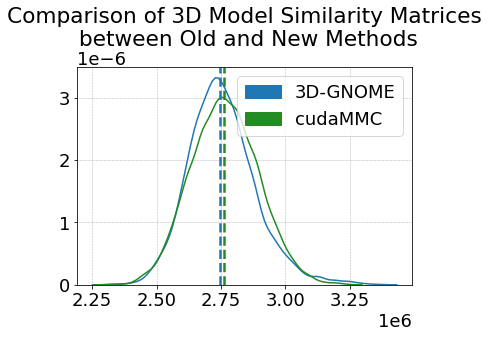

In [32]:
plt.clf()
plt.figsize = (2.36,1.57)
plt.rcParams.update({'font.size': 18})
plt.tight_layout()

sns.distplot(df_distance_3dnome[['similarity_distance']], hist=False, rug=False, color='tab:blue')
sns.distplot(df_distance_cudaMMC[['similarity_distance']], hist=False, rug=False, color='forestgreen')

plt.axvline(x=df_distance_3dnome.similarity_distance.median(),
            color='tab:blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=df_distance_cudaMMC.similarity_distance.median(),
            color='forestgreen',
            ls='--', 
            lw=2.5)

plt.title("Comparison of 3D Model Similarity Matrices\n between Old and New Methods", y=1.07)

blue_patch = mpatches.Patch(color='tab:blue', label='3D-GNOME')
green_patch = mpatches.Patch(color='forestgreen', label='cudaMMC')
plt.legend(handles=[blue_patch, green_patch], loc=0, frameon=True)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.savefig("figures/similarity_matrices_hg19_cpu_vs_gpu",dpi=300,bbox_inches='tight',pad_inches=0.1)
plt.show()


## Median Similarity Distance Analysis

This line computes the ratio of the median similarity distance values for models generated by `cudaMMC` and `3D-GNOME`. The result indicates how similar the medians of the two methods are. A ratio very close to 1 (e.g., within 1% difference) would suggest that both methods have nearly identical median similarity distance values for the analyzed data.



In [33]:
df_distance_cudaMMC.similarity_distance.median()/df_distance_3dnome.similarity_distance.median()

1.006128929441759

## Time Performance Barplot

The barplot visualizes the differences in time performance between the `cudaMMC` and `3D-GNOME` methods. By marking the standard deviation on the barplot, we provide a measure of the variability or spread of the time performance data for each method. A smaller standard deviation indicates that the time performances are closely clustered around the mean, whereas a larger standard deviation suggests more variability in the performance times.


In [34]:
def upload_data(files_time):
    results = {}
    for i in files_time:
        with open(i, 'r') as f:
            t=float(f.readline())/60
            chrom_name = 'chr'+i.split('/')[-1].split('_')[0]
            if chrom_name in results.keys():
                results[chrom_name].append(t)
            else:
                results[chrom_name]=[t]   
    return results

In [35]:
def transform_to_long(df, method_name):
    df = pd.DataFrame(df).melt(var_name="Chromosome", value_name=method_name)
    return df


In [36]:
files_time_cpu = [os.path.join(paths_3dnome_logs, fname) for fname in os.listdir(paths_3dnome_logs) if fname.endswith('txt')]
files_time_gpu = [os.path.join(paths_cudaMMC_logs, fname) for fname in os.listdir(paths_cudaMMC_logs) if fname.endswith('txt')]

data_cpu = upload_data(files_time_cpu)
data_gpu = upload_data(files_time_gpu)

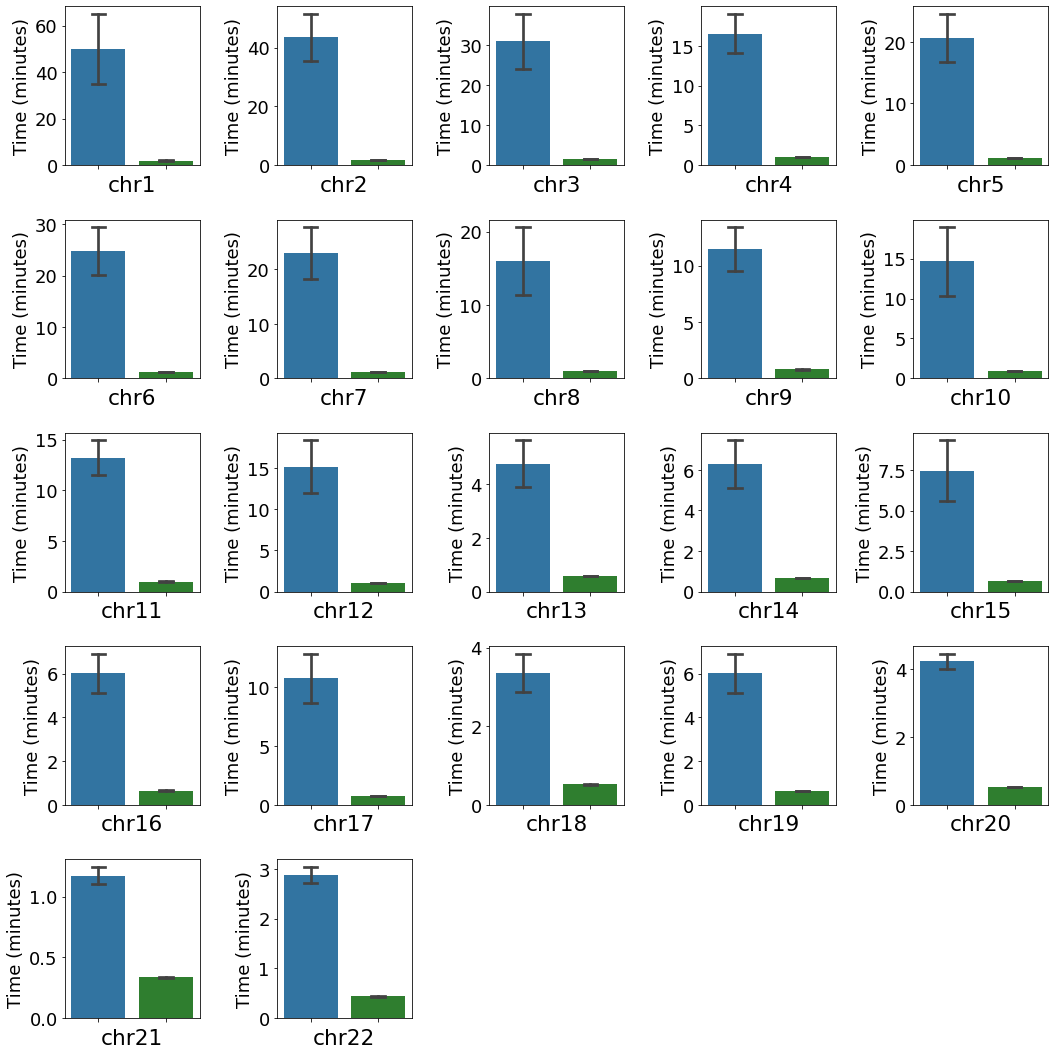

In [37]:
data = {
    'chromosome': [],
    'method': [],
    'value': [] 
}

chromosome_keys = list(data_cpu.keys())
chromosome_keys.sort(key=lambda x: int(x.replace("chr", "")) if x[3:].isdigit() else float('inf'))

for chrom in chromosome_keys:
    data['chromosome'].extend([chrom] * len(data_cpu[chrom]))
    data['method'].extend(['3D-GNOME'] * len(data_cpu[chrom]))
    data['value'].extend(np.array(data_cpu[chrom]))

    data['chromosome'].extend([chrom] * len(data_gpu[chrom]))
    data['method'].extend(['cudaMMC'] * len(data_gpu[chrom]))
    data['value'].extend(np.array(data_gpu[chrom]))

df = pd.DataFrame(data)
palette_dict = {'3D-GNOME': 'tab:blue', 'cudaMMC': 'forestgreen'}

plt.figure(figsize=(15, 15))
for idx, chrom in enumerate(chromosome_keys, start=1):
    plt.subplot(5, 5, idx)
    
    sns.barplot(data=df[df['chromosome'] == chrom], x='method', y='value', ci="sd", capsize=.2, palette=palette_dict)
    
    plt.title(chrom.replace("Chromosome", "chr"), y=-0.2)
    plt.xlabel('')
    plt.ylabel('Time (minutes)')
    plt.tight_layout()
    plt.gca().set_xticklabels([])

# plt.savefig("figures/barplots_time_performance", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
